# Reducing

Reducing is a principles that will be used to merge two different states, when both are supposed to be used in the following nodes.

In [1]:
from typing import TypedDict, Annotated
from langgraph.graph import START, END, StateGraph

## Invalid Update

If langgraph has two updates to the state and it cannot select one, it throws the `InvalidUpdateError`.

---

The following cell shows a regular graph with two flows join at the `END` node, and both their version of the state.

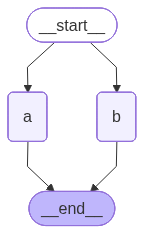

In [2]:
class State(TypedDict):
    out: str


def node_a(state: State) -> State:
    return State(out="A output")


def node_b(state: State) -> State:
    return State(out="B output")


builder = StateGraph(State)

builder.add_node("a", node_a)
builder.add_node("b", node_b)
builder.add_edge(START, "a")
builder.add_edge(START, "b")

graph = builder.compile()
graph

Executing such a graph results in the error displayed in the following cell.

In [3]:
try:
    graph.invoke(State(out="start"))
except Exception as e:
    print(type(e).__name__, ":", e)

InvalidUpdateError : At key 'out': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://docs.langchain.com/oss/python/langgraph/errors/INVALID_CONCURRENT_GRAPH_UPDATE


## Sequential

Note that if you've defined the reducer for the state attribute of the graph, the sequential state updates will also be merged.

---

Consider the following example: the `attr1` does not have a reducer function, but to the `attr2` does. Sequentially connected nodes simply return state updates with a list with a single random value.

In [4]:
import random
import operator


class State(TypedDict):
    attr1: list[int]
    attr2: Annotated[list[int], operator.add]


def gen_value():
    return random.randint(5, 10)


def node1(state: State) -> dict:
    return {"attr1": [gen_value()], "attr2": [gen_value()]}


def node2(state: State) -> State:
    return State(attr1=[gen_value()], attr2=[gen_value()])


graph = (
    StateGraph(State)
    .add_node("node1", node1)
    .add_node("node2", node2)

    .add_edge(START, "node1")
    .add_edge("node1", "node2")
    .add_edge("node2", END)
    .compile()
)

The following cell applies the graph.

In [42]:
graph.invoke(State(attr1=[1], attr2=[2]))

{'attr1': [9], 'attr2': [2, 5, 10]}

Despite the fact that there is no branching in the graph, the generated values are **appended** to attributes that have reducers, rather than replacing them. For attributes without reducers, `InvalidUpdateError` is not raised because there is no **ambiguous** update - the new value just replaces the previous value in the graph.

## Messages

In agent flow development, it is common practice to merge the messages from the different nodes. To add new messages to the list of messages, use `langcahin.graph.message.add_messages` as a reduce function.

---

The following cell generates the graph using the `langgraph.graph.message.add_message` as a reducer function. The only node that the graph uses simply adds an extra message to the messages list.

In [9]:
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, BaseMessage


class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]


def a(state: State) -> State:
    return State(messages=[HumanMessage("Message from the a")])


graph = (
    StateGraph(State)
    .add_node("a", a)
    .add_edge("__start__", "a")
    .add_edge("a", "__end__")
    .compile()
)

The following cell shows how an additional message from node "a" is added to the input message.

In [10]:
graph.invoke(State(messages=[HumanMessage("Input message")]))["messages"]

[HumanMessage(content='Input message', additional_kwargs={}, response_metadata={}, id='05ce9be2-0154-4a98-a8f9-e2cc4e44c994'),
 HumanMessage(content='Message from the a', additional_kwargs={}, response_metadata={}, id='21d9b690-c35f-4d8f-a37e-fe7a6e11158b')]

### Re-writing

In `BaseMessage` you can specify the id of the message. The `langgraph.graph.message.add_message` reducer function replaces the message by a provided in a new state with a same id. 

---

The following cell defines a graph a single node that returns a state with the attribute `id=1`. The graph invocation passes the different massage but with `id=1` as well:

In [27]:
def a(state: State) -> State:
    return State(messages=[HumanMessage("Message from the a", id=1)])


out = (
    StateGraph(State)
    .add_node("a", a)
    .add_edge(START, "a")
    .add_edge("a", END)
    .compile()
).invoke(State(
    messages=[
        HumanMessage("Original message", id=1)
    ]
))

for m in out['messages']:
    m.pretty_print()

================================ Human Message =================================

Message from the a


As a result, the graph returns the message added to the node, ignoring the original message passed to it.

## Custom reducer

You can define your own reducer function. This function must take two arguments - the values of the annotated with this attribute from different updates of the graph - and return a reduced value.

---

The following cell creates a using a custom reducer function that simply adds the values of the `val` attribute from the different states.

In [8]:
def my_reducer(val1: int, val2: int):
    return val1 + val2


class State(TypedDict):
    val: Annotated[int, my_reducer]


def node(state: State) -> dict:
    return {"val": 10}


(
    StateGraph(State)
    .add_node("node", node)
    .add_edge(START, "node")
    .add_edge("node", END)
    .compile()
).invoke({"val": 1})

{'val': 11}